In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.datasets import make_classification

In [2]:
pd.set_option('display.max_columns', None)
# load the data
data = pd.read_csv('../data/classification_df.csv')

data

,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,test_Propoxyphene_0,test_Amphetamines_0,test_Cannabinoids_0,test_Benzodiazepines_0,test_MMethadone_0,test_Oxycodone_0,test_Cocaine_0,test_Methamphetamine_0,test_Opiate300_0,test_Propoxyphene_1,test_Amphetamines_1,test_Cannabinoids_1,test_Benzodiazepines_1,test_MMethadone_1,test_Oxycodone_1,test_Cocaine_1,test_Methamphetamine_1,test_Opiate300_1,test_Propoxyphene_2,test_Amphetamines_2,test_Cannabinoids_2,test_Benzodiazepines_2,test_MMethadone_2,test_Oxycodone_2,test_Cocaine_2,test_Methamphetamine_2,test_Opiate300_2,test_Propoxyphene_3,test_Amphetamines_3,test_Cannabinoids_3,test_Benzodiazepines_3,test_MMethadone_3,test_Oxycodone_3,test_Cocaine_3,test_Methamphetamine_3,test_Opiate300_3,test_Propoxyphene_4,test_Amphetamines_4,test_Cannabinoids_4,test_Benzodiazepines_4,test_MMethadone_4,test_Oxycodone_4,test_Cocaine_4,test_Methamphetamine_4,test_Opiate300_4,cows_predose,cows_postdose,dsm_cannabis_abuse,dsm_cannabis_dependence,dsm_cannabis_no_diagnosis,dsm_cannabis_not_evaluated,dsm_cannabis_not_present,dsm_cocaine_abuse,dsm_cocaine_dependence,dsm_cocaine_no_diagnosis,dsm_cocaine_not_evaluated,dsm_cocaine_not_present,dsm_sedative_abuse,dsm_sedative_dependence,dsm_sedative_no_diagnosis,dsm_sedative_not_evaluated,dsm_sedative_not_present,dsm_opiates_abuse,dsm_opiates_dependence,dsm_opiates_not_evaluated,dsm_opiates_not_present,dsm_alcohol_abuse,dsm_alcohol_dependence,dsm_alcohol_no_diagnosis,dsm_alcohol_not_evaluated,dsm_alcohol_not_present,dsm_amphetamine_abuse,dsm_amphetamine_dependence,dsm_amphetamine_no_diagnosis,dsm_amphetamine_not_evaluated,dsm_amphetamine_not_present,mdh_liver_problems_no_history,mdh_liver_problems_not_evaluated,mdh_liver_problems_yes_history,mdh_kidney_problems_no_history,mdh_kidney_problems_not_evaluated,mdh_kidney_problems_yes_history,mdh_alc_withdrawal_no_history,mdh_alc_withdrawal_not_evaluated,mdh_alc_withdrawal_yes_history,mdh_schizophrenia_no_history,mdh_schizophrenia_not_evaluated,mdh_schizophrenia_yes_history,mdh_major_depressive_disorder_no_history,mdh_major_depressive_disorder_not_evaluated,mdh_major_depressive_disorder_yes_history,mdh_bipolar_disorder_no_history,mdh_bipolar_disorder_not_evaluated,mdh_bipolar_disorder_yes_history,mdh_anxiety_disorder_no_history,mdh_anxiety_disorder_not_evaluated,mdh_anxiety_disorder_yes_history,mdh_sig_neurological_damage_no_history,mdh_sig_neurological_damage_not_evaluated,mdh_sig_neurological_damage_yes_history,mdh_allergies_no_history,mdh_allergies_not_evaluated,mdh_allergies_yes_history,mdh_gi_problems_no_history,mdh_gi_problems_not_evaluated,mdh_gi_problems_yes_history,mdh_thyroid_problems_no_history,mdh_thyroid_problems_not_evaluated,mdh_thyroid_problems_yes_history,mdh_heart_condition_no_history,mdh_heart_condition_not_evaluated,mdh_heart_condition_yes_history,mdh_asthma_no_history,mdh_asthma_not_evaluated,mdh_asthma_yes_history,mdh_hypertension_no_history,mdh_hypertension_not_evaluated,mdh_hypertension_yes_history,mdh_skin_disease_no_history,mdh_skin_disease_not_evaluated,mdh_skin_disease_yes_history,mdh_head_injury_no_history,mdh_head_injury_not_evaluated,mdh_head_injury_yes_history,mdh_opi_withdrawal_no_history,mdh_opi_withdrawal_not_evaluated,mdh_opi_withdrawal_yes_history,mdh_epilepsy_no_history,mdh_epilepsy_not_evaluated,mdh_epilepsy_yes_history,pex_lymph_nodes_abnormal,pex_lymph_nodes_normal,pex_lymph_nodes_not_evaluated,pex_lymph_nodes_not_present,pex_other_abnormal,pex_other_normal,pex_other_not_evaluated,pex_other_not_present,pex_respiratory_abnormal,pex_respiratory_normal,pex_respiratory_not_evaluated,pex_respiratory_not_present,pex_musculoskeletal_abnormal,pex_musculoskeletal_normal,pex_musculoskeletal_not_evaluated,pex_musculoskeletal_not_present,pex_gi_system_abnormal,pex_gi_system_normal,pex_gi_system_n

In [3]:
list(data.columns)

['rsa_week_0',
 'rsa_week_1',
 'rsa_week_2',
 'rsa_week_3',
 'rsa_week_4',
 'meds_methadone_0',
 'meds_buprenorphine_0',
 'meds_methadone_1',
 'meds_buprenorphine_1',
 'meds_methadone_2',
 'meds_buprenorphine_2',
 'meds_methadone_3',
 'meds_buprenorphine_3',
 'meds_methadone_4',
 'meds_buprenorphine_4',
 'test_Propoxyphene_0',
 'test_Amphetamines_0',
 'test_Cannabinoids_0',
 'test_Benzodiazepines_0',
 'test_MMethadone_0',
 'test_Oxycodone_0',
 'test_Cocaine_0',
 'test_Methamphetamine_0',
 'test_Opiate300_0',
 'test_Propoxyphene_1',
 'test_Amphetamines_1',
 'test_Cannabinoids_1',
 'test_Benzodiazepines_1',
 'test_MMethadone_1',
 'test_Oxycodone_1',
 'test_Cocaine_1',
 'test_Methamphetamine_1',
 'test_Opiate300_1',
 'test_Propoxyphene_2',
 'test_Amphetamines_2',
 'test_Cannabinoids_2',
 'test_Benzodiazepines_2',
 'test_MMethadone_2',
 'test_Oxycodone_2',
 'test_Cocaine_2',
 'test_Methamphetamine_2',
 'test_Opiate300_2',
 'test_Propoxyphene_3',
 'test_Amphetamines_3',
 'test_Cannabinoids_

In [9]:
#tests = data[[col for col in data.columns if col.startswith('test_')]].iloc[:, :9]
#drug_names = [re.sub(r"^.*?_(.*?)_.*$", r"\1", s) for s in tests.columns]
#drug_names

['Propoxyphene',
 'Amphetamines',
 'Cannabinoids',
 'Benzodiazepines',
 'MMethadone',
 'Oxycodone',
 'Cocaine',
 'Methamphetamine',
 'Opiate300']

## Assign Target Variable and Combine

## Classification Workflow

In [14]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np



# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.2
validation = 0.1
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(data,
                      target='dropout',
                      train_size=train,                        
                      test_size=test,
                      valid_size=validation)

# print shape of all data sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (1341, 193)
Shape of X_val: (192, 193)
Shape of X_test: (384, 193)


In [5]:
gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
	'subsample': [0.3, 0.5, 0.9],
    'max_depth': [3, 6, 9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring='roc_auc', cv=4, verbose=1, return_train_score=True)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'objective': 'binary:logistic', 'subsample': 0.3}
Highest ROC AUC found:  0.8882475257811205


In [15]:
# refit the model with the best params
best_params = grid_auc.best_params_
best_gbm = xgb.XGBClassifier(**best_params)
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

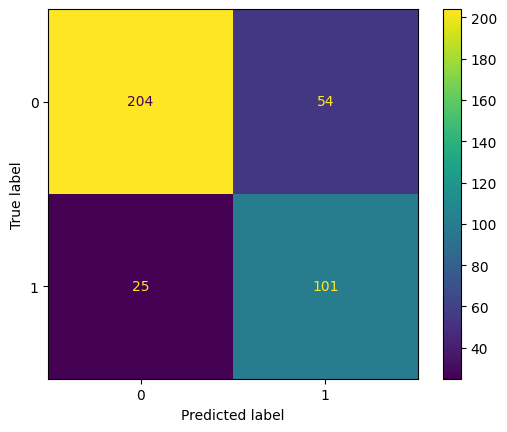

In [16]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot();

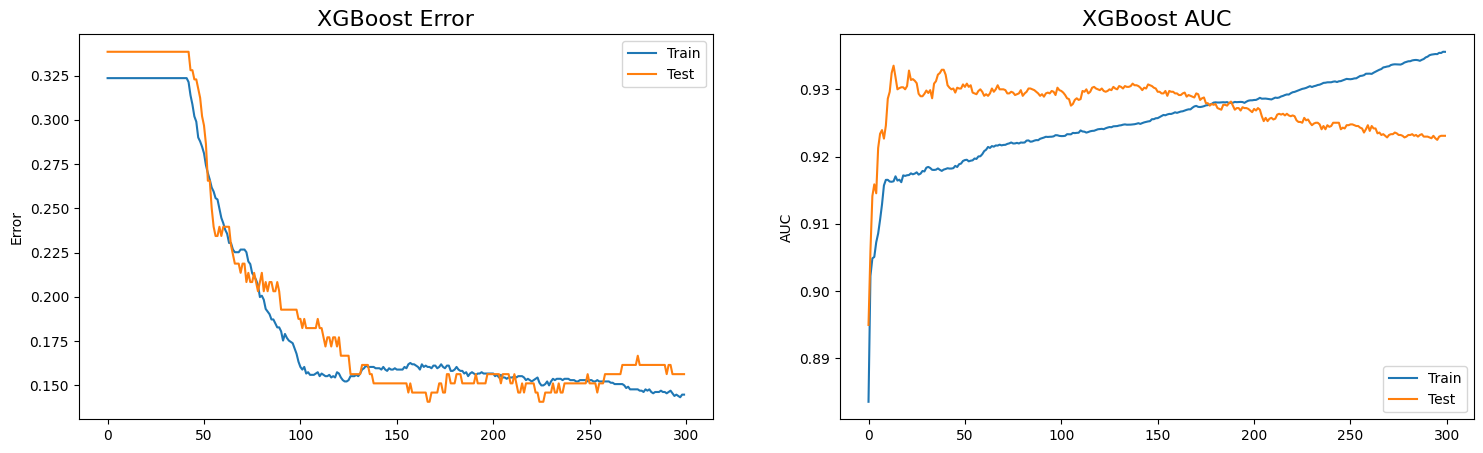

In [17]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [18]:
# Print the classification report
from sklearn.metrics import classification_report, accuracy_score
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

# print accuracy for train, val and test
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy: ", accuracy_score(y_val, y_pred_val))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))


Train Accuracy:  0.8553318419090231
Validation Accuracy:  0.84375
Test Accuracy:  0.7942708333333334


In [19]:
# print classification report for training
print('Train Classification Report')
print(classification_report(y_train, y_pred_train))

Train Classification Report
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89       907
         1.0       0.73      0.87      0.79       434

    accuracy                           0.86      1341
   macro avg       0.83      0.86      0.84      1341
weighted avg       0.87      0.86      0.86      1341



In [20]:
# Print the classification report for test
print("Test classification report:")
print(classification_report(y_test, y_pred_test))

Test classification report:
              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84       258
         1.0       0.65      0.80      0.72       126

    accuracy                           0.79       384
   macro avg       0.77      0.80      0.78       384
weighted avg       0.81      0.79      0.80       384



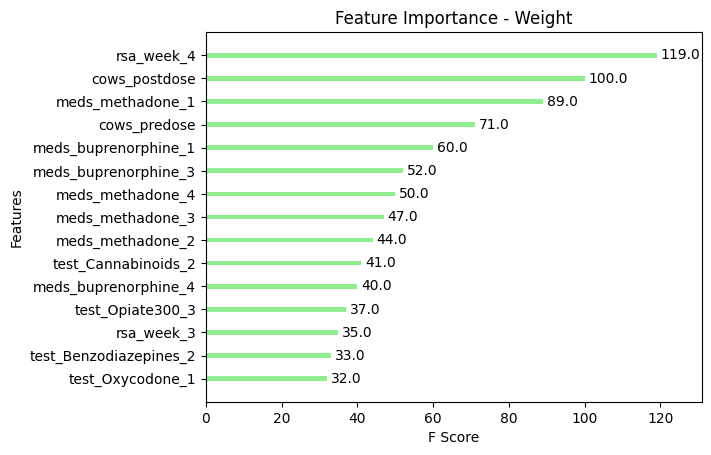

In [21]:
# plot feature importance
xgb.plot_importance(grid_auc.best_estimator_, importance_type='weight', max_num_features=15, title='Feature Importance - Weight', xlabel='F Score', ylabel='Features', color='lightgreen', grid=False)
plt.show()

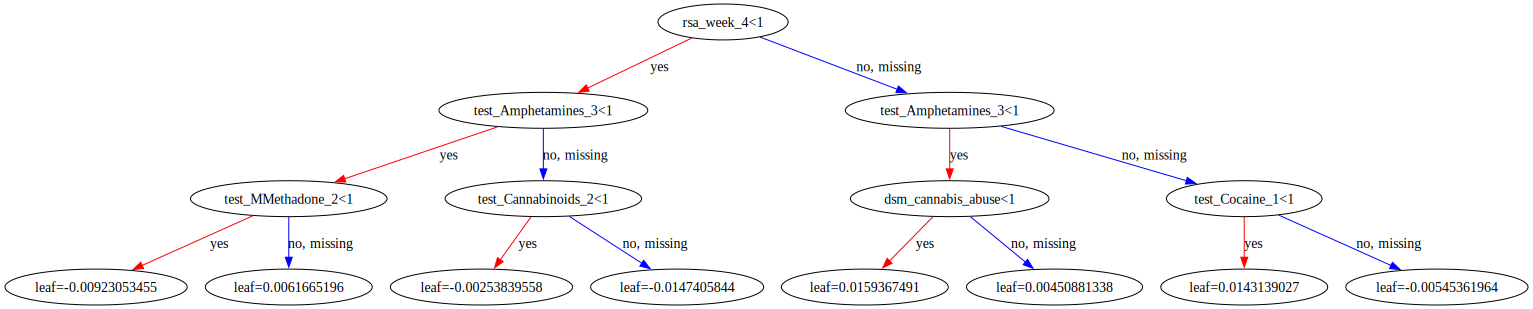

In [22]:
# Assuming 'xg_reg' is your trained XGBoost model
graph = xgb.to_graphviz(grid_auc.best_estimator_, num_trees=0)
# can I print the num trees argument?

# Display the tree plot directly in the notebook
graph